In [1]:
import gym
import matplotlib.pyplot as plt
import numpy as np

from IPython import display

In [2]:
env = gym.make("MountainCar-v0")

TIME_LIMIT = 400
env = gym.wrappers.TimeLimit(
    gym.envs.classic_control.MountainCarEnv(),
    max_episode_steps=TIME_LIMIT + 1,
)

print(f"Action space: {env.action_space}")
print(f"Observation space: {env.observation_space}")

s = env.reset()
print(f"Initial state: {s}")

Action space: Discrete(3)
Observation space: Box(2,)
Initial state: [-0.41747321  0.        ]


In [3]:
x_high, v_high = env.observation_space.high
x_low, v_low = env.observation_space.low

x_deepest = -0.5

n_actions = env.action_space.n - 1

print(x_high, x_low)
print(v_high, v_low)

n_actions

target_actions = [0, 1]
n_actions = 2

0.6 -1.2
0.07 -0.07


In [4]:
# create agent
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(20, 20),
    activation='relu',
    warm_start=True,  # keep progress between .fit(...) calls
    max_iter=1,  # make only 1 iteration on each .fit(...)
)

# initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()] * n_actions, target_actions)

/home/redcyb/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(20, 20), learning_rate='constant',
              learning_rate_init=0.001, max_iter=1, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=True)

In [5]:
import math

def generate_session(t_max=200):

    states, actions = [], []
    total_reward = 0

    s = env.reset()
    
    x, v = s
    
    old_sign = v > 0

    for t in range(t_max):

        probs = agent.predict_proba([s])[0]

        a = np.random.choice(target_actions, p=probs)
        
        new_s, r, done, info = env.step(0 if a == 0 else 2)
    
        x, v = new_s
        
        new_sign = v > 0

        states.append(s)
        actions.append(a)
        
#         r2 = math.exp(abs(v * 50))
#         + 0.1 / (0.6 - x)

        r2 = (abs(x - x_deepest) * 10) + (0.1 / (0.6 - x))
    
#         r2 = 2 if old_sign == new_sign else -10

        total_reward += r + r2

        s = new_s
        
        old_sign = new_sign
        
        if done:
            break
            
    return states, actions, total_reward

In [6]:
# _ss = generate_session(t_max=10)
# _ss

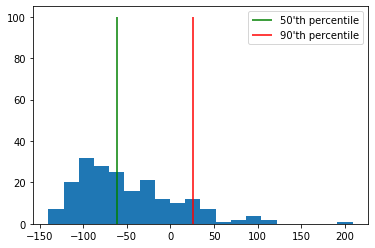

In [7]:
# let's see the initial reward distribution
import matplotlib.pyplot as plt
%matplotlib inline

sample_rewards = [generate_session()[-1] for _ in range(200)]

plt.hist(sample_rewards, bins=20)
plt.vlines([np.percentile(sample_rewards, 50)], [0], [100], label="50'th percentile", color='green')
plt.vlines([np.percentile(sample_rewards, 90)], [0], [100], label="90'th percentile", color='red')
plt.legend()

In [8]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):
    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_mask = np.asarray(rewards_batch) >= reward_threshold
    elite_states = np.asarray(states_batch)[elite_mask]
    elite_actions = np.asarray(actions_batch)[elite_mask]

    return np.concatenate(elite_states), np.concatenate(elite_actions)

In [9]:
def show_progress(rewards_batch, log, percentile, reward_range=[-990, 100]):
    mean_reward = np.mean(rewards_batch)
    threshold = np.percentile(rewards_batch, percentile)
    log.append([mean_reward, threshold])

    display.clear_output(True)
    print("mean reward = %.3f, threshold=%.3f" % (mean_reward, threshold))
    plt.figure(figsize=[8, 4])
    plt.subplot(1, 2, 1)
    plt.plot(list(zip(*log))[0], label='Mean rewards')
    plt.plot(list(zip(*log))[1], label='Reward thresholds')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.hist(rewards_batch, range=reward_range)
    plt.vlines([np.percentile(rewards_batch, percentile)],
               [0], [100], label="percentile", color='red')
    plt.legend()
    plt.grid()

    plt.show()

In [10]:
# create agent
from sklearn.neural_network import MLPClassifier

agent = MLPClassifier(
    hidden_layer_sizes=(10, 10),
    activation='relu',
    warm_start=True,  # keep progress between .fit(...) calls
    max_iter=1,  # make only 1 iteration on each .fit(...)
    learning_rate_init=0.01
)

# initialize agent to the dimension of state an amount of actions
agent.fit([env.reset()] * n_actions, target_actions)

/home/redcyb/anaconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(10, 10), learning_rate='constant',
              learning_rate_init=0.01, max_iter=1, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=True)

mean reward = 516.080, threshold=640.838


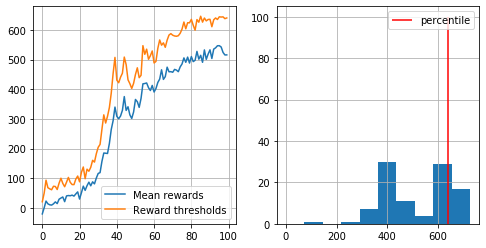

[[-4.78783025e-01  0.00000000e+00]
 [-4.78118132e-01  6.64893573e-04]
 [-4.78793286e-01 -6.75153884e-04]
 ...
 [-1.20000000e+00  0.00000000e+00]
 [-1.19675810e+00  3.24189604e-03]
 [-1.19226366e+00  4.49444542e-03]]
[1 0 0 ... 1 0 1]
You Win! You may stop training now via KeyboardInterrupt.


In [11]:
n_sessions = 100
percentile = 80
log = []

for i in range(100):
    # generate new sessions
    sessions = [generate_session(200) for _ in range(n_sessions)]

    states_batch, actions_batch, rewards_batch = map(np.array, zip(*sessions))

    elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile)
    
    agent.fit(elite_states, elite_actions)

    show_progress(rewards_batch, log, percentile, reward_range=[0, np.max(rewards_batch)])

    print(elite_states)
    print(elite_actions)

    if np.mean(rewards_batch) > 190:
        print("You Win! You may stop training now via KeyboardInterrupt.")
        
    if np.mean(rewards_batch) > 1000:
        break

In [19]:
import time

s = env.reset()

for step in range(1000):

    probs = agent.predict_proba([s])[0]

    a = np.random.choice(target_actions, p=probs)

    new_s, r, done, info = env.step(0 if a == 0 else 2)

    x, v = new_s

    s = new_s

    display.clear_output()
    env.render()

    if done:
        break

print(f"Spent: {step}")

Spent: 148


In [20]:
# record sessions
import gym.wrappers
env = gym.wrappers.Monitor(
    gym.make("MountainCar-v0"), 
    directory="videos", 
    force=True
)

sessions = [generate_session() for _ in range(5)]
env.close()

In [14]:
# # show video
# from IPython.display import HTML
# import os

# video_names = list(filter(lambda s: s.endswith(".mp4"), os.listdir("./videos/")))

# HTML("""
#      <video width="640" height="480" controls><source src="{}" type="video/mp4">
# </video>
# """.format("./videos/"+video_names[0]))  # this may or may not be _last_ video. Try other indices